In [ ]:
%%capture
!pip install rdkit
!pip install torch_geometric

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from math import sqrt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors


import torch.nn.functional as F
from torch.utils.data import random_split

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.nn import AttentiveFP

In [ ]:
import os
import random
from collections import Counter

import torch

from torch_geometric.data import InMemoryDataset, download_url, extract_gz
from torch_geometric.utils import from_smiles
from sklearn.metrics import r2_score

In [ ]:
# print(plt.style.available)
plt.style.use('ggplot')

In [ ]:
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
seed_set()

## **Loading Dataset**

In [ ]:
df = pd.read_csv('Lipophilicity.csv')

In [ ]:
df.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


## **Data Analysis**

In [ ]:
df.describe()

,exp
count,4200.000000
mean,2.186336
std,1.203004
min,-1.500000
25%,1.410000
50%,2.360000
75%,3.100000
max,4.500000


In [ ]:
# make sure there are no duplicates
df['smiles'].nunique()

4200

Text(0, 0.5, 'Count')

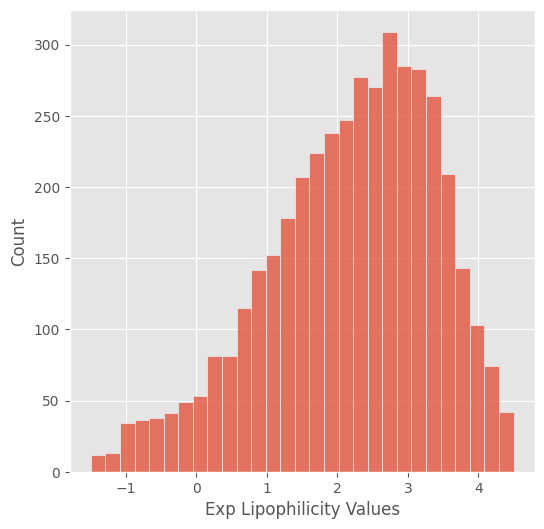

In [ ]:
# distribution of exp lipophilicity values

plt.figure(figsize=(6,6))
sns.histplot(data=df, x='exp', y=None, hue=None)
# plt.hist(df['exp'], bins=30)
plt.xlabel('Exp Lipophilicity Values')
plt.ylabel('Count')

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles', molCol='mol')

In [ ]:
df.head()

,CMPD_CHEMBLID,exp,smiles,mol
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d690>
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d7e0>
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d700>
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d770>
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2fd80>


In [ ]:
mwt = []
for mol in df['mol']:
  MW = Descriptors.MolWt(mol)
  mwt.append(MW)

df['molwt'] = mwt

In [ ]:
df.head()

,CMPD_CHEMBLID,exp,smiles,mol,molwt
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d690>,340.858
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d7e0>,494.591
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d700>,321.829
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d770>,419.890
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2fd80>,381.480


Text(0, 0.5, 'Count')

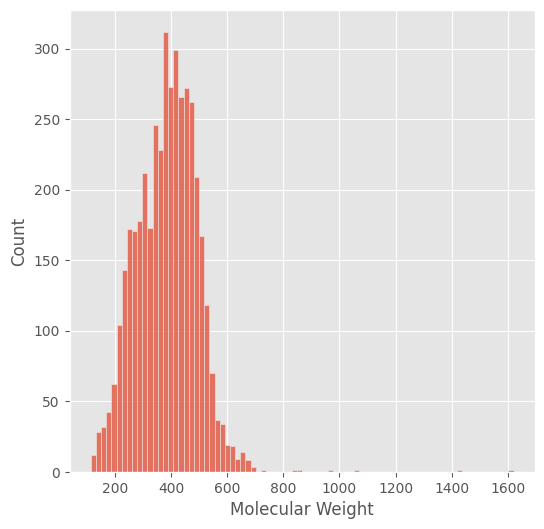

In [ ]:
# Distribution of Molecular Weight in Raw Dataset

plt.figure(figsize=(6,6))
sns.histplot(data=df, x='molwt', y=None, hue=None)
# plt.hist(df['exp'], bins=30)
plt.xlabel('Molecular Weight')
plt.ylabel('Count')

In [ ]:
high_mwt = df[df['molwt'] > 700]
high_mwt

,CMPD_CHEMBLID,exp,smiles,mol,molwt
364,CHEMBL1094250,3.48,C[C@@H](CNC(=O)c1c(O)c(O)cc2c(O)c(c(C)cc12)c3c...,<rdkit.Chem.rdchem.Mol object at 0x7f51b1b35e00>,700.788
442,CHEMBL1214185,1.80,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,<rdkit.Chem.rdchem.Mol object at 0x7f51b1b380b0>,837.058
905,CHEMBL443684,0.64,CC1(C)CCC(=C(CN2CCN(CC2)c3ccc(cc3)C(=O)NS(=O)(...,<rdkit.Chem.rdchem.Mol object at 0x7f51b1b44cf0>,974.634
1236,CHEMBL2170837,4.20,CCn1c(C)c(C(=O)O)c(c2cccc(c2)N3CCN(CC3)c4ccc(N...,<rdkit.Chem.rdchem.Mol object at 0x7f51b1b4dee0>,1065.703
1397,CHEMBL1200558,-0.46,CC[C@H](C)[C@H](N)C1=N[C@@H](CS1)C(=O)N[C@@H](...,<rdkit.Chem.rdchem.Mol object at 0x7f51b1b525e0>,1422.720
1646,CHEMBL3545252,3.40,O.O.O.CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@]3(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f51b1b593f0>,861.935
3592,CHEMBL387675,-0.94,CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f51b1b8eea0>,1620.693
3780,CHEMBL163,4.30,CC(C)[C@H](NC(=O)N(C)Cc1csc(n1)C(C)C)C(=O)N[C@...,<rdkit.Chem.rdchem.Mol object at 0x7f51b1b94200>,720.962


In [ ]:
high_mwt.shape

(8, 5)

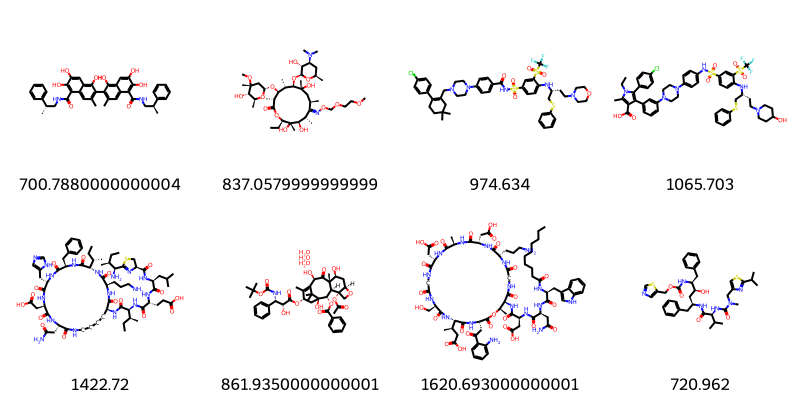

In [ ]:
img=Draw.MolsToGridImage(high_mwt['mol'], molsPerRow=4, subImgSize=(200,200),legends=[str(x) for x in high_mwt['molwt']])
img

In [ ]:
smiles = high_mwt['smiles']
df_final = df[~df['smiles'].isin(smiles)]

In [ ]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles,mol,molwt
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d690>,340.858
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d7e0>,494.591
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d700>,321.829
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d770>,419.890
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2fd80>,381.480


In [ ]:
df_final.shape

(4192, 5)

In [ ]:
# df_final = df_final[['CMPD_CHEMBLID', 'exp', 'smiles']]
# df_final.to_csv('Lipophilicity_final.csv', index=None)

Text(0, 0.5, 'Count')

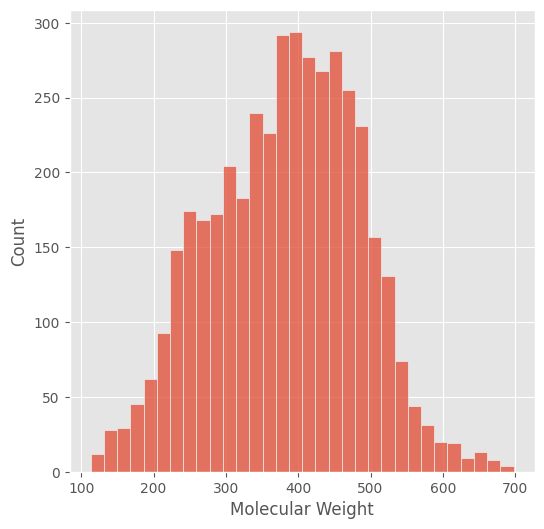

In [ ]:
# Distribution of Molecular Weight in Truncated Dataset

plt.figure(figsize=(6,6))
sns.histplot(data=df_final, x='molwt', y=None, hue=None)
# plt.hist(df['exp'], bins=30)
plt.xlabel('Molecular Weight')
plt.ylabel('Count')

In [ ]:
df_final = df_final.reset_index(drop=True)

In [ ]:
df_final.describe()

,exp,molwt
count,4192.000000,4192.000000
mean,2.186591,381.915338
std,1.201077,102.456833
min,-1.500000,113.160000
25%,1.410000,306.440750
50%,2.360000,388.370500
75%,3.100000,456.576500
max,4.500000,697.778000


In [ ]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles,mol,molwt
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d690>,340.858
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d7e0>,494.591
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d700>,321.829
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2d770>,419.890
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f51b3d2fd80>,381.480


In [ ]:
unique_atoms = set()
for mol in df_final['mol']:
  for atom in mol.GetAtoms():
    a = atom.GetSymbol()
    unique_atoms.add(a)

In [ ]:
unique_atoms

{'B', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'Se', 'Si'}

In [ ]:
atom_list = []
for mol in df_final['mol']:
  for atom in mol.GetAtoms():
    a = atom.GetSymbol()
    atom_list.append(a)

In [ ]:
Counter(atom_list)

Counter({'C': 83065,
         'N': 14505,
         'Cl': 1288,
         'O': 10679,
         'S': 1580,
         'F': 1760,
         'B': 6,
         'Br': 100,
         'P': 3,
         'I': 7,
         'Si': 1,
         'Se': 1})

In [ ]:
dict_ = { 'N': 14505,
         'Cl': 1288,
         'O': 10679,
         'S': 1580,
         'F': 1760,
         'B': 6,
         'Br': 100,
         'P': 3,
         'I': 7,
         'Si': 1,
         'Se': 1}

In [ ]:
df_freq = pd.DataFrame(dict_.items(), columns = ['Atoms', 'Count']).sort_values('Count', ascending=False)

In [ ]:
df_freq.head()

,Atoms,Count
0,N,14505
2,O,10679
4,F,1760
3,S,1580
1,Cl,1288


<ipython-input-35-f894340493f7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_freq, x = 'Atoms', y = 'Count', palette = 'Set2')


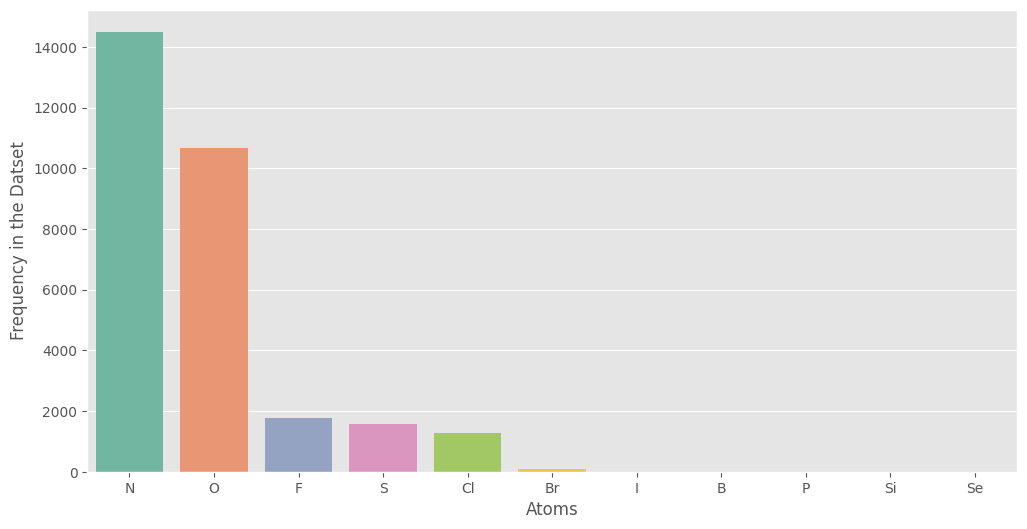

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(df_freq, x = 'Atoms', y = 'Count', palette = 'Set2')
plt.ylabel('Frequency in the Datset')
plt.show()

In [ ]:
# b_mols = [Chem.MolFromSmiles(x) for x in b_smiles[-50:]]
# img=Draw.MolsToGridImage(b_mols,molsPerRow=4,subImgSize=(400,400))
# img

In [ ]:
atom_list = ['B', 'Br','Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'Se', 'Si']
dict_2 = {}
for i in range(len(atom_list)):
  count=0
  for mol in df_final["mol"]:
    all_atoms = set()
    for atom in mol.GetAtoms():
      a = atom.GetSymbol()
      all_atoms.add(a)
    if atom_list[i] in all_atoms:
      count+=1
    dict_2[atom_list[i]] = count

In [ ]:
dict_2

{'B': 6,
 'Br': 96,
 'Cl': 974,
 'F': 899,
 'I': 4,
 'N': 4039,
 'O': 3814,
 'P': 3,
 'S': 1352,
 'Se': 1,
 'Si': 1}

In [ ]:
df_freq_2 = pd.DataFrame(dict_2.items(), columns = ['Atoms', 'Count']).sort_values('Count', ascending=False)

<ipython-input-40-44274c9ec8a9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_freq_2, x = 'Atoms', y = 'Count', palette = 'Set2')


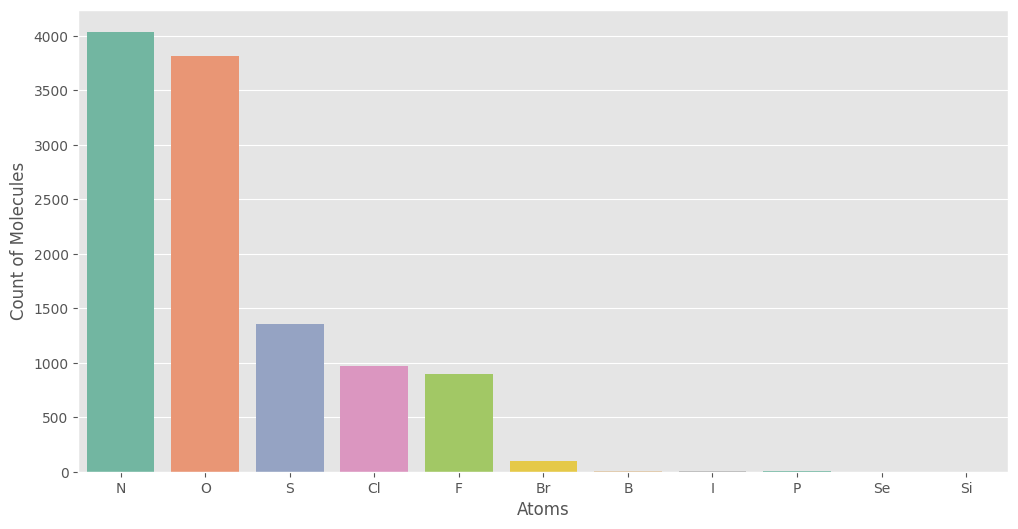

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(df_freq_2, x = 'Atoms', y = 'Count', palette = 'Set2')
plt.ylabel('Count of Molecules')
plt.show()

## **Generating and Analyzing Graphs**

In [ ]:
df_final = pd.read_csv('Lipophilicity_final.csv')

In [ ]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [ ]:
smile = df_final['smiles'][92]

In [ ]:
smile

'CN(C)C(=O)c1ccc(CN2CCc3cc4nc(N)sc4cc3CC2)cc1'

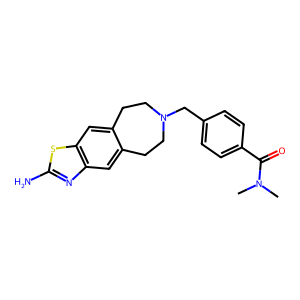

In [ ]:
mol = Chem.MolFromSmiles(smile)
img = Draw.MolToImage(mol)
img

In [ ]:
g = from_smiles(smile, with_hydrogen=False)
g

Data(x=[27, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CN(C)C(=O)c1ccc(CN2CCc3cc4nc(N)sc4cc3CC2)cc1')

In [ ]:
# type(g)

In [ ]:
g.x.dtype

torch.int64

In [ ]:
g.x

tensor([[ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 7,  0,  3,  5,  0,  0,  3,  0,  0],
        [ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 6,  0,  3,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  0],
        [ 7,  0,  3,  5,  0,  0,  4,  0,  1],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  1],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 7,  0,  2,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 7,  0,  3,  5,  2,  0,  3,  0,  0],
        [16,  0,  2,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  

In [ ]:
g.num_nodes

27

In [ ]:
g.num_node_features

9

In [ ]:
g.edge_index

tensor([[ 0,  1,  1,  1,  2,  3,  3,  3,  4,  5,  5,  5,  6,  6,  7,  7,  8,  8,
          8,  9,  9, 10, 10, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15, 15, 15,
         16, 16, 17, 17, 17, 18, 19, 19, 20, 20, 20, 21, 21, 22, 22, 22, 23, 23,
         24, 24, 25, 25, 26, 26],
        [ 1,  0,  2,  3,  1,  1,  4,  5,  3,  3,  6, 26,  5,  7,  6,  8,  7,  9,
         25,  8, 10,  9, 11, 24, 10, 12, 11, 13, 12, 14, 22, 13, 15, 14, 16, 20,
         15, 17, 16, 18, 19, 17, 17, 20, 15, 19, 21, 20, 22, 13, 21, 23, 22, 24,
         10, 23,  8, 26,  5, 25]])

In [ ]:
g.edge_attr

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  1],
        [ 1,  0,  0],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [12,  0,  1],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [1

In [ ]:
g

In [ ]:
G = to_networkx(g)

In [ ]:
type(G)

networkx.classes.digraph.DiGraph

In [ ]:
G.number_of_nodes()

27

In [ ]:
list(G.nodes)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26]

In [ ]:
G.number_of_edges()

60

In [ ]:
list(G.edges)

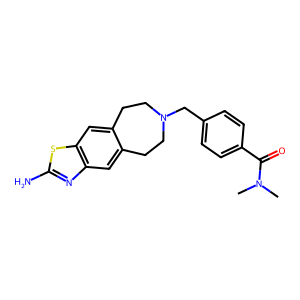

In [ ]:
img

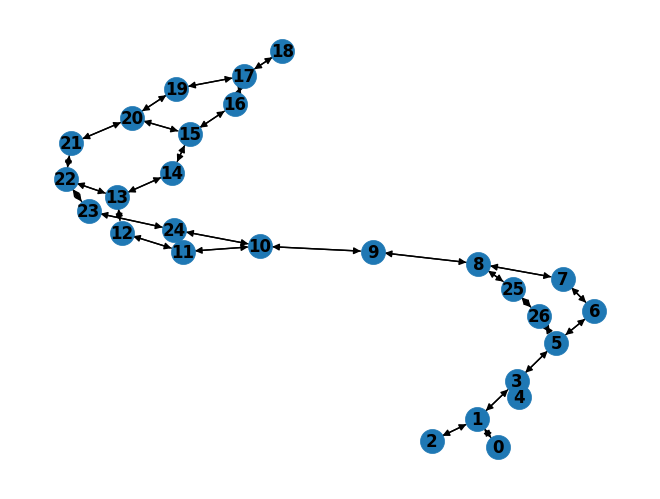

In [ ]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.savefig("G.png")

# **Generate Graphs for the Whole Dataset**

In [ ]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [ ]:
graph_list = []
for i, smile in enumerate(df_final['smiles']):
  g = from_smiles(smile)
  g.x = g.x.float()
  y = torch.tensor(df_final['exp'][i], dtype=torch.float).view(1, -1)
  g.y = y
  graph_list.append(g)

In [ ]:
type(graph_list[0])

torch_geometric.data.data.Data

In [ ]:
graph_list[1]

Data(x=[33, 9], edge_index=[2, 70], edge_attr=[70, 3], smiles='COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', y=[1, 1])

In [ ]:
graph_list[1].y

In [ ]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])
        # For PyG<2.4:
        # self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return 'Lipophilicity.csv'

    @property
    def processed_file_names(self):
        return 'data.dt'

    def download(self):
        # Download to `self.raw_dir`.
        # download_url(url, self.raw_dir)
        pass

    def process(self):
        # Read data into huge `Data` list.
        graph_list = []
        for i, smile in enumerate(df_final['smiles']):
          g = from_smiles(smile)
          g.x = g.x.float()
          y = torch.tensor(df_final['exp'][i], dtype=torch.float).view(1, -1)
          g.y = y
          graph_list.append(g)


        data_list = graph_list

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

In [ ]:
lipo = MyOwnDataset(root = '/content/')

In [ ]:
type(lipo)

__main__.MyOwnDataset

In [ ]:
lipo[23]


Data(x=[31, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OC(=O)c1cccc(c1)N2CCC(CN3CCC(CC3)Oc4ccc(Cl)c(Cl)c4)CC2', y=[1, 1])

In [ ]:
lipo[23].y

tensor([[2.1700]])

In [ ]:
len(lipo)

4192